In [4]:
from thewalrus import hafnian, tor, quantum, samples, reduction, symplectic, threshold_detection_prob
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
from sympy.utilities.iterables import multiset_permutations
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg'] 
import time
import random
import math
from itertools import *  

In [5]:
# functions

def prob_tor(cov, sub_mat):
    
    
    Husimi_big = quantum.Qmat(cov)
    
    dim = len(Husimi_big) 
    
    det_hu =  np.linalg.det(Husimi_big)
    
    denominator = det_hu**0.5
    
    if np.any(sub_mat) == 0:
        
        return((1/denominator).real)
    
    else:
    
        Husimi_sub = quantum.Qmat(sub_mat)

        dim_sub = len(Husimi_sub) 
        
        O = np.eye(dim_sub) - np.linalg.inv(Husimi_sub) 

        Tor = tor(O)

        return (Tor/denominator).real

def prob_exact(M):
    
    m = len(M)
    stat =  np.zeros((m+1), dtype = np.float32) 
    
    for i in range(m+1):
        permut = []
        list_0 = [1 for j in range(i)]
        list_0 += [0]*(m - i)   
        permut += multiset_permutations(list_0)

        if i == 0:
            stat[i] += 1.

        else:
            for j in range(len(permut)):
                stat[i] += Z_i(M,  permut[j])


    for c in range(m):
        for h in range(c+1, m+1):
            stat[h] -= stat[c]*round(fact(m-c)/(fact(h-c)*fact(m - h)))

    s = 0.
    for i in range(m+1):
        s += stat[i]
        
    return stat/s

def prob_sectors_exact(M):
    
    m = len(M)
    Nu = 10*m 
    dnu = 2*np.pi/Nu 
    
    stat =  np.zeros((m+1, Nu), dtype = np.complex128) 
    sectors =  np.zeros((m+1, Nu), dtype = np.complex128) 
            
            
    for n in range(m+1):
            
        permut = []
        list_0 = [1 for j in range(n)]
        list_0 += [0]*(m - n)   
        permut += multiset_permutations(list_0)


        if n == 0:
             for nu in range(Nu):
                stat[n,nu] +=  1.

        else:

            for nu in range(Nu):
                for k in range(len(permut)):            
                    stat[n,nu] += Z_i_v(M, nu*dnu, permut[k])


    for k in range(m):
        for h in range(k+1, m+1):
            for nu in range(Nu):
                stat[h,nu] -= stat[k,nu]*round(fact(m-k)/(fact(h-k)*fact(m - h)))



    for n in range(m+1):
        for j in range(Nu):
            for k in range(Nu):
                sectors[n,j] += stat[n,k]*np.exp(-1j*j*k*dnu)/Nu 
                    
    return sectors.real


def Z_i(E, list_det):
    
    list_det_1 = covert_01_0123(list_det)            
    
    Ei = red_mat(E, list_det_1)
    
    E_i = Ei.conjugate()@Ei
    
#     II = np.eye(len(E_i))
    
#     Zi = (np.linalg.det(II - 4*E_i))**(-0.5)

    eig = np.linalg.eigh(E_i)[0]
    
    Zi = 1. 
    
    for i in range(len(eig)):
        
        Zi *= (1 - 4*eig[i])**(-0.5)
    
    return Zi.real 


def Z(M):
    
    M = M.conjugate().T@M
    
#     II = np.eye(len(M))
    
#     z = (np.linalg.det(II - 4*M))**(-0.5)
    
    eig = np.linalg.eigh(M)[0]
    
    z = 1. 
    
    for i in range(len(eig)):
        
        z *= (1 - 4*eig[i])**(-0.5)
    
    return z.real 


def Z_i_v(E, nu, list_det):
    
    Zi = 1.
    
    list_det_1 = covert_01_0123(list_det)
            
    
    Ei = red_mat(E, list_det_1)
    
    E_i = Ei.conjugate()@Ei
    
#     II = np.eye(len(E_i))
    
#     Zi = (np.linalg.det(II - 4*np.exp(1j*nu)*E_i))**(-0.5)
    
    eig = np.linalg.eigh(E_i)[0]
    
    for i in range(len(eig)):
        p = 4*np.exp(1j*nu)*eig[i]
        Zi *= (1 - p)**(-0.5)
    
    return Zi


def covert_01_0123(list_det):
    
    #[0,1,1,0] - input 
    #[1,2] - output
    
    list_det_1 = [] 
    
    for i in range(len(list_det)):
        if list_det[i] == 1:
            list_det_1.append(i)
    
    return list_det_1


def fact(x):
    
    res = 1
    
    for i in range(int(x)):
        res *=(i+1)
        
    return res

def red_mat(M_big, list_det): # [0, ..., n,k,l, ..., m-1] - numbers of clicked detectors     
   
    
    n = len(list_det)
    
    small_mat =  np.zeros((n, n), dtype = np.complex128)
    
    # [0,+,0,+] == [1,3]
    
    for i in range(n):
        for j in range(n):
            ind_i = list_det[i]
            ind_j = list_det[j]
            small_mat[i,j] = M_big[ind_i,ind_j]
    
    return small_mat



In [7]:
# parameters

path = r'data/demo' 

data_VS = np.genfromtxt(path + '/Initial_state.dat')

m = len(data_VS) - 1

r = []
phi = []

for i in range(1, m+1):
    r.append(data_VS[i,1])
        
for i in range(1, m+1):
    phi.append(data_VS[i,2])


data_U = np.genfromtxt(path + '/Parmeters_of_interferometer.dat')


N_BS = len(data_U) - 1
N_PS = 2*N_BS

Phi_list_1 = np.zeros(N_BS)
Phi_list_2 = np.zeros(N_BS)
alfa_list = np.zeros(N_BS)

ind_list = []

for i in range(N_BS):
    ind_list.append([int(data_U[i+1,0]),int(data_U[i+1,1])])


for i in range(N_BS):
    Phi_list_1[i] = data_U[i+1,2]

for i in range(N_BS):
    Phi_list_2[i] = data_U[i+1,3]

for i in range(N_BS):
    alfa_list[i] = data_U[i+1,4]
    
data_M = np.genfromtxt(path + '/GBS_matrix.dat')


M =  np.zeros((m, m),dtype=np.complex128)

real_part = []
imaginary_part = []

for i in range(m):
    for k in range(0,2*m,2):
        real_part.append(data_M[i,k])
        
for i in range(m):
    for k in range(1,2*m+1,2):
        imaginary_part.append(data_M[i,k])

for i in range(m*m):
    M[i//m,i%m] = real_part[i] + 1j*imaginary_part[i]

    
print('Input:','\n')
print('n_modes = ', m ,'\n')
print('r = ', r,'\n')
print('phi = ', phi,'\n')
print('Interferometer:','\n')
print('N_bs = ',N_BS, ', N_ps = ', N_PS ,'\n')


Input: 

n_modes =  8 

r =  [1.5, 1.5, 1.5, 1.5, 0.0, 0.0, 0.0, 0.0] 

phi =  [1.53672, 0.14297, 2.15673, 0.12049, 0.0, 0.0, 0.0, 0.0] 

Interferometer: 

N_bs =  320 , N_ps =  640 



In [8]:
possible_values = (0,1)
n_positions = m

sorted_combinations = combinations_with_replacement(possible_values, n_positions)

unique_permutations = set()

for combo in sorted_combinations:
    for p in permutations(combo):
        unique_permutations.add(p)

unique_permutations = sorted(unique_permutations)
print("Number of unique permutations: %i" % (len(unique_permutations)))
# for p in unique_permutations:
#     print(p)

Number of unique permutations: 256


In [9]:
# We check our exact results with the Walrus library https://the-walrus.readthedocs.io 
# Here we want to prove that our expressions are in the same units as the conventional GBS problem. 

prog = sf.Program(m)

eng = sf.Engine("gaussian")

with prog.context as q:
    
    for i in range(m):
        
        Sgate(r[i], phi[i])| q[i]

    for k in range(N_BS):       
        
        Rgate(Phi_list_1[k]) | q[ind_list[k][0]]
        BSgate(alfa_list[k]) | (q[ind_list[k][1]], q[ind_list[k][0]])
        Rgate(Phi_list_2[k]) | q[ind_list[k][1]]
            
    
state = eng.run(prog).state

mu = state.means()
cov = state.cov()

In [10]:
# start_time = time.process_time()

print("P [s a m p l e] ", "         walrus", "        ours", '\n' )

comb = len(unique_permutations) 

P_list_walrus = [] 
P_list_ours = [] 

P_sum_walrus = np.zeros(m+1)
P_sum_ours = prob_exact(M)


for p in unique_permutations:
    
    k = list(p).count(1)
    list_det = covert_01_0123(list(p))
    
    if k != 0: 
        M_sub = red_mat(M, list_det)
        norm = Z(M_sub)/Z(M)
        P_list_ours.append(norm*prob_exact(M_sub)[k])
        
    else:
        
        P_list_ours.append(prob_exact(M)[k])
        

    if k == m:
        P_list_walrus.append(prob_tor(cov, cov))
        P_sum_walrus[k] = prob_tor(cov, cov)
        
    else:    
        P_list_walrus.append(threshold_detection_prob(mu, cov, list(p))) #threshold_detection_prob_parallel
        P_sum_walrus[k] += threshold_detection_prob(mu, cov, list(p))
         
    
for k in range(comb):
    
    print('P', list(unique_permutations[k]), ' = ',  "{:.3e}".format(P_list_walrus[k]), ' | ', "{:.3e}".format(P_list_ours[k]) ) 
    
sum_prob_walrus = 0
sum_prob_ours = 0

for i in range(comb):
    sum_prob_walrus +=  P_list_walrus[i]
    sum_prob_ours +=  P_list_ours[i]

print('\n',"sum prob:","{:.3e}".format(sum_prob_walrus), '|', "{:.3e}".format(sum_prob_ours),  '\n')

for i in range(m+1):
    print('n =',i, '|', '  P_walrus = ', "{:.3e}".format(P_sum_walrus[i]), '  P_ours = ', "{:.3e}".format(P_sum_ours[i]))


# print('\n',"--- %s minutes ---" % ((time.process_time() - start_time)/60))

P [s a m p l e]           walrus         ours 



/tmp/ipykernel_9/34118179.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


P [0, 0, 0, 0, 0, 0, 0, 0]  =  3.265e-02-3.366e-19j  |  3.265e-02
P [0, 0, 0, 0, 0, 0, 0, 1]  =  2.008e-03+1.218e-18j  |  2.008e-03
P [0, 0, 0, 0, 0, 0, 1, 0]  =  2.778e-04+3.372e-18j  |  2.778e-04
P [0, 0, 0, 0, 0, 0, 1, 1]  =  7.032e-03+1.001e-18j  |  7.032e-03
P [0, 0, 0, 0, 0, 1, 0, 0]  =  1.593e-05+5.658e-19j  |  1.593e-05
P [0, 0, 0, 0, 0, 1, 0, 1]  =  1.801e-03+7.970e-19j  |  1.801e-03
P [0, 0, 0, 0, 0, 1, 1, 0]  =  1.356e-03-6.354e-20j  |  1.356e-03
P [0, 0, 0, 0, 0, 1, 1, 1]  =  1.378e-03+1.873e-18j  |  1.378e-03
P [0, 0, 0, 0, 1, 0, 0, 0]  =  9.818e-04+2.048e-18j  |  9.818e-04
P [0, 0, 0, 0, 1, 0, 0, 1]  =  5.467e-03-1.260e-18j  |  5.467e-03
P [0, 0, 0, 0, 1, 0, 1, 0]  =  7.706e-03-3.006e-19j  |  7.706e-03
P [0, 0, 0, 0, 1, 0, 1, 1]  =  7.151e-03+2.101e-18j  |  7.151e-03
P [0, 0, 0, 0, 1, 1, 0, 0]  =  6.483e-04-4.510e-20j  |  6.483e-04
P [0, 0, 0, 0, 1, 1, 0, 1]  =  7.654e-04-2.847e-19j  |  7.654e-04
P [0, 0, 0, 0, 1, 1, 1, 0]  =  1.145e-03+2.629e-19j  |  1.145e-03
P [0, 0, 0

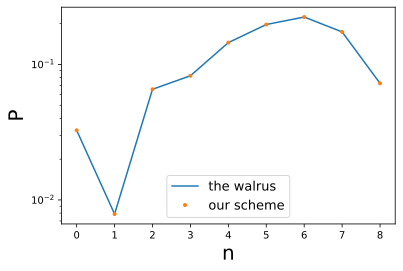

In [11]:
n_cl = [i for i in range(m+1)]
plt.plot(n_cl, P_sum_walrus, label = 'the walrus')
plt.plot(n_cl, P_sum_ours, '.', label = 'our scheme')
plt.yscale('log')
plt.legend(prop={'size':13}, loc='lower center')
plt.xlabel(r'n',fontsize=20)
plt.ylabel(r'P',fontsize=20)
plt.show()

In [12]:
# Calculation the probabilities via sectors 

print("P [s a m p l e] ", "         exact", "   sum over sectors", '\n' )
    
# P[random sample] 

N_comb = unique_permutations.index((1,1,0,1,0,1,0,1))

list_det = list(unique_permutations[N_comb])

n_tar = list_det.count(1)

list_det_ = covert_01_0123(list_det)

M_sub = red_mat(M, list_det_)

P_sectors =  prob_sectors_exact(M_sub)

norm = 1/Z(M)

P_ = 0

for nu in range(10*n_tar):
    P_ += P_sectors[n_tar,nu]*norm
    
print('P',list_det, ' = ', "{:.3e}".format(P_list_ours[N_comb]) ,'  ', "{:.3e}".format(P_))
    
    

P [s a m p l e]           exact    sum over sectors 

P [1, 1, 0, 1, 0, 1, 0, 1]  =  2.939e-03    2.939e-03


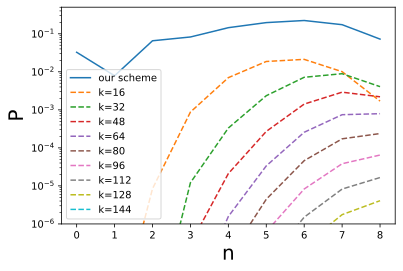

In [13]:
# Sectors for the last point of P(n) ( P[1,1,1,1,1,1] ) 

P_sectors =  prob_sectors_exact(M)

plt.plot(n_cl, P_sum_ours, '-', label = 'our scheme')

for nu in range(m,m*10,m):
    plt.plot([i for i in range(m+1)], [P_sectors[j,nu]/Z(M) for j in range(m+1)],'--' ,label = 'k='+str(2*nu))
plt.yscale('log')
plt.legend(prop={'size':10}, loc='lower left')
plt.xlabel(r'n',fontsize=20)
plt.ylabel(r'P',fontsize=20)
plt.ylim([10**(-6),10**(-0.3)])
plt.show()

In [14]:
# Moments calculation 

# Import minors 

Nu = 10*m

data_minors = np.genfromtxt(path + r'/Minors0-1.dat')
data_minors2 = np.genfromtxt(path + r'/Minors2.dat')
data_minors3 = np.genfromtxt(path + r'/Minors3.dat')
data_minors4 = np.genfromtxt(path + r'/Minors4.dat')

p2 = round(fact(m)/(fact(m-2)*2)) 
p3 = round(fact(m)/(fact(m - 3)*fact(3)))
p4 = round(fact(m)/(fact(m - 4)*fact(4)))


Z_v_0 = np.zeros((Nu),dtype=np.complex128)

Z_v_1 = np.zeros((m, Nu),dtype=np.complex128)

Z_v_2 = np.zeros((p2, Nu),dtype=np.complex128)

Z_v_3 = np.zeros((p3, Nu),dtype=np.complex128)

Z_v_4 = np.zeros((p4, Nu),dtype=np.complex128)

for j in range(Nu):
     Z_v_0[j] =  data_minors[j,1:2] + 1j*data_minors[j,2:3]
        
for j in range(Nu):
    for n in range(0,2*m,2):
        Z_v_1[n//2,j] =  data_minors[j,int(3+n)] + 1j*data_minors[j,int(4+n)] 

for j in range(Nu):
    for n in range(0,2*p2,2):
        Z_v_2[n//2,j] =  data_minors2[j,int(1+n)] + 1j*data_minors2[j,int(2+n)] 
        
for j in range(Nu):
    for n in range(0,2*p3,2):
        Z_v_3[n//2,j] =  data_minors3[j,int(1+(n))] + 1j*data_minors3[j,int(2+(n))] 
        
for j in range(Nu):
    for n in range(0,2*p4,2):
        Z_v_4[n//2,j] =  data_minors4[j,int(1+(n))] + 1j*data_minors4[j,int(2+(n))] 
        
        
Z_v_0f = np.fft.fft(Z_v_0)/Nu
Z_v_1f = np.fft.fft(Z_v_1)/Nu            
Z_v_2f = np.fft.fft(Z_v_2)/Nu
Z_v_3f = np.fft.fft(Z_v_3)/Nu
Z_v_4f = np.fft.fft(Z_v_4)/Nu 

In [15]:
# Moments calculation

mean_ = np.zeros(Nu)
disp_ = np.zeros(Nu)
m3_ = np.zeros(Nu)
m4_ = np.zeros(Nu)
m5_ = np.zeros(Nu)

def moment_formula(n, *args):
    
    m = 0 
    
    for x in args:
            moments = x
    
    if n == 2:
        m = moments[0] + 2*moments[1] - moments[0]**2
        
    if n == 3:
        m = moments[0] + 6*moments[1] + 6*moments[2] - 3*mean_[nu]*(moments[0] + 2*moments[1]) +  2*moments[0]**3
       
    if n == 4:
        m_2 = moments[0] + 2*moments[1]
        
        m_3 = moments[0] + 6*moments[1] + 6*moments[2]
        
        m_4 = moments[0] + 14*moments[1] + 36*moments[2] + 24*moments[3]
        
        m =  m_4 - 4*m_3*moments[0]- 3*m_2**2 + 12*m_2*moments[0]**2 - 6*moments[0]**4
        
    return m


n_ij_v =  np.zeros(Nu)
n_ijk_v = np.zeros(Nu)
n_ijkl_v = np.zeros(Nu)
n_ijklp_v = np.zeros(Nu)

ind_2 = []
ind_3 = []
ind_4 = []


for i in range(m):
        for j in range(i+1, m):
            ind_2.append([i,j]) 

for i in range(m):
        for j in range(i+1, m):
            for k in range(j+1, m):
                ind_3.append([i,j,k]) 
                
for i in range(m):
    for j in range(i+1, m):
        for k in range(j+1, m):
            for l in range(k+1, m):
                ind_4.append([i,j,k,l]) 


for z in range(Nu): 
    for j in range(m):
        mean_[z] += 1 - (Z_v_1f[j,z]/Z_v_0f[z]).real
        

for nu in range(Nu):
    i_ = 0
    for i in range(m):
        for j in range(i+1, m):
            n_ij_v[nu] += 1 - (( Z_v_1f[j,nu] + Z_v_1f[i,nu] - Z_v_2f[i_,nu])/Z_v_0f[nu]).real
            i_ += 1
    disp_[nu] =  moment_formula(2, [mean_[nu], n_ij_v[nu]])
            

for nu in range(Nu):
    i_= 0
    for i in range(m):
        for j in range(i+1, m):
            for k in range(j+1, m):
                
                z1 = ind_2.index([i,j])
                z2 = ind_2.index([i,k])
                z3 = ind_2.index([j,k])
                
                n_ijk_v[nu] += 1 - ((Z_v_1f[i,nu] + Z_v_1f[j,nu] + Z_v_1f[k,nu] - Z_v_2f[z1,nu] - Z_v_2f[z2,nu] - Z_v_2f[z3,nu] + Z_v_3f[i_,nu])/Z_v_0f[nu]).real
                i_ += 1 
                
    m3_[nu] = moment_formula(3, [mean_[nu], n_ij_v[nu], n_ijk_v[nu]])
    
for nu in range(Nu): 
    i_= 0
    for i in range(m):
        for j in range(i+1, m):
            for k in range(j+1, m):
                for l in range(k+1, m):

                    z1 = ind_2.index([i,j])
                    z2 = ind_2.index([i,k])
                    z3 = ind_2.index([i,l])

                    z4 = ind_2.index([j,k])
                    z5 = ind_2.index([k,l])
                    z6 = ind_2.index([j,l])

                    h1 = ind_3.index([i,j,k])
                    h2 = ind_3.index([j,k,l])
                    h3 = ind_3.index([i,k,l])
                    h4 = ind_3.index([i,j,l])

                    n_ijkl_v[nu] += 1 - ((Z_v_1f[i,nu] + Z_v_1f[j,nu] + Z_v_1f[k,nu] + Z_v_1f[l,nu] - Z_v_2f[z1,nu] - Z_v_2f[z2,nu] - Z_v_2f[z3,nu] - Z_v_2f[z4,nu] - Z_v_2f[z5,nu] - Z_v_2f[z6,nu] + Z_v_3f[h1,nu] + Z_v_3f[h2,nu] +  Z_v_3f[h3,nu] + Z_v_3f[h4,nu] -  Z_v_4f[i_,nu])/Z_v_0f[nu]).real 
                    
                    i_ += 1 

    m4_[nu] = moment_formula(4, [mean_[nu], n_ij_v[nu], n_ijk_v[nu], n_ijkl_v[nu]])

In [16]:
# Approximation 
old_settings = np.seterr(all='ignore') 
def gauss_fun(x, *args):
    
    for c in args:
        c = args
    
    if len(c) == 3:    
    
        res = c[0]*np.exp(-(x - c[1])**2/(2*c[2])) 
        
    if len(c) == 4:
        
        res = c[0]*np.exp(-(x - c[1])**2/(2*c[2])) * np.exp(+ c[3]*(x - c[1])**3/(6*c[2]**3)) 
        
    if len(c) == 5:
        
        res = c[0]*np.exp(-(x - c[1])**2/(2*c[2])) * np.exp(+ c[3]*(x - c[1])**3/(6*c[2]**3)) * np.exp(+ c[4]*(x - c[1])**4/(8*c[2]**4))
    
        
    return res



mu0 = np.zeros(Nu)
mu1 = np.zeros(Nu)
mu2 = np.zeros(Nu)
mu3 = np.zeros(Nu)
mu4 = np.zeros(Nu)

for nu in range(Nu): 
    mu0[nu] = (Z_v_0f[nu]/Z_v_0[0]).real
    mu1[nu] = mean_[nu]
    mu2[nu] = disp_[nu]
    mu3[nu] = m3_[nu]
    mu4[nu] = m4_[nu]

n_cut = int(m+1)


# 2 order 

A_2 = np.zeros(Nu)
Mu1_2 = np.zeros(Nu)
Mu2_2 = np.zeros(Nu)

for nu in range(Nu):

    A_2[nu] =  mu0[nu] 
    Mu1_2[nu] = mu1[nu] 
    Mu2_2[nu] = mu2[nu] 


    for z in range(300):
        s0 = 0
        s1 = 0 
        s2 = 0 
        s3 = 0
        s4 = 0

        for j in range(n_cut):

            s0 +=  gauss_fun(j, A_2[nu], Mu1_2[nu], Mu2_2[nu])
            s1 +=  gauss_fun(j, A_2[nu], Mu1_2[nu], Mu2_2[nu])* j
            s2 +=  gauss_fun(j, A_2[nu], Mu1_2[nu], Mu2_2[nu])* j**2
            
        if s0==s0:

            mu0_ = s0 
            mu1_ = s1/s0 
            mu2_ = s2/s0 - mu1_**2

            A_2[nu] += 0.1*(mu0[nu]  - mu0_ )
            Mu1_2[nu] += 0.1*(mu1[nu] - mu1_) 
            Mu2_2[nu] += 0.1*(mu2[nu] - mu2_)  
            
        else:
            
            A_2[nu] += 0
            Mu1_2[nu] += 0
            Mu2_2[nu] += 0
            
            
# 3 order 

A_3 = np.zeros(Nu)
Mu1_3 = np.zeros(Nu)
Mu2_3 = np.zeros(Nu)
Mu3_3 = np.zeros(Nu)


for nu in range(Nu):

    A_3[nu] = mu0[nu]
    Mu1_3[nu] = mu1[nu] 
    Mu2_3[nu] = mu2[nu] 
    Mu3_3[nu] = 0



    for z in range(500):
        s0 = 0
        s1 = 0 
        s2 = 0 
        s3 = 0

        for j in range(n_cut):

            s0 += gauss_fun(j, A_3[nu], Mu1_3[nu], Mu2_3[nu], Mu3_3[nu])
            s1 += gauss_fun(j, A_3[nu], Mu1_3[nu], Mu2_3[nu], Mu3_3[nu])* j
            s2 += gauss_fun(j, A_3[nu], Mu1_3[nu], Mu2_3[nu], Mu3_3[nu])* j**2
            s3 += gauss_fun(j, A_3[nu], Mu1_3[nu], Mu2_3[nu], Mu3_3[nu])* j**3
            
        
        if s0==s0:

            mu0_ = s0 
            mu1_ = s1/s0 
            mu2_ = s2/s0 - mu1_**2
            mu3_ = s3/s0 - 3*mu2_*mu1_ - mu1_**3
            
            A_3[nu] += 0.05*(mu0[nu] - mu0_)
            Mu1_3[nu] += 0.1*(mu1[nu] - mu1_ )
            Mu2_3[nu] += 0.1*(mu2[nu] - mu2_)  
            Mu3_3[nu] += 0.05*(mu3[nu] - mu3_) 
            
        else:
            A_3[nu] += 0
            Mu1_3[nu] += 0
            Mu2_3[nu] += 0
            Mu3_3[nu] += 0 
            
A_4 = np.zeros(Nu)
Mu1_4 = np.zeros(Nu)
Mu2_4 = np.zeros(Nu)
Mu3_4 = np.zeros(Nu)
Mu4_4 = np.zeros(Nu)


for nu in range(Nu):

    A_4[nu] = mu0[nu]
    Mu1_4[nu] = mu1[nu] 
    Mu2_4[nu] = mu2[nu] 
    Mu3_4[nu] = 0 
    Mu4_4[nu] = 0 
    

    for z in range(700):

        s0 = 0
        s1 = 0 
        s2 = 0 
        s3 = 0
        s4 = 0

        for j in range(n_cut):

            s0 +=  gauss_fun(j, A_4[nu], Mu1_4[nu], Mu2_4[nu], Mu3_4[nu], Mu4_4[nu])
            s1 +=  gauss_fun(j, A_4[nu], Mu1_4[nu], Mu2_4[nu], Mu3_4[nu], Mu4_4[nu])* j
            s2 +=  gauss_fun(j, A_4[nu], Mu1_4[nu], Mu2_4[nu], Mu3_4[nu], Mu4_4[nu])* j**2
            s3 +=  gauss_fun(j, A_4[nu], Mu1_4[nu], Mu2_4[nu], Mu3_4[nu], Mu4_4[nu])* j**3
            s4 +=  gauss_fun(j, A_4[nu], Mu1_4[nu], Mu2_4[nu], Mu3_4[nu], Mu4_4[nu])* j**4

        if s0==s0:
            mu0_ = s0 
            mu1_ = s1/s0 
            mu2_ = s2/s0 - mu1_**2
            mu3_ = s3/s0 - 3*mu2_*mu1_ - mu1_**3
            mu4_ = s4/s0 - 4*mu3_*mu1_ - 3*mu2_**2 - 6*mu2_*mu1_**2 - mu1_**4
    
            step_ini_0 =  0.1
            step_ini_1 =  0.1
            step_ini_2 =  0.1
            step_ini_3 =  0.05
            step_ini_4 =  0.008
            
            A_4[nu] +=  step_ini_0*(mu0[nu] - mu0_) 
            Mu1_4[nu] +=  step_ini_1*(mu1[nu] - mu1_)
            Mu2_4[nu] +=  step_ini_2*(mu2[nu] - mu2_) 
            Mu3_4[nu] +=  step_ini_3*(mu3[nu] - mu3_) 
            Mu4_4[nu] +=  step_ini_4*(mu4[nu] - mu4_)
            
        else:
            A_4[nu] += 0
            Mu1_4[nu] += 0
            Mu2_4[nu] += 0 
            Mu3_4[nu] += 0 
            Mu4_4[nu] += 0

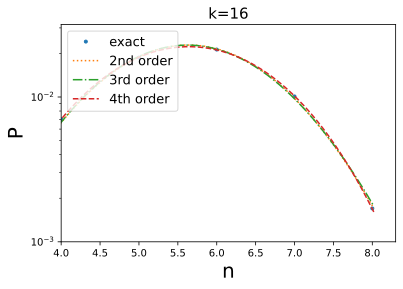

In [17]:
P_sectors =  prob_sectors_exact(M)
k_ex = int(m)

for nu in range(k_ex,k_ex+1):
    iN = 100 
    di = (m+0.1)/iN
    
    
    line1, = plt.plot([i for i in range(m+1)], [P_sectors[j,nu]/Z(M) for j in range(m+1)],'.' ,label = 'exact')
    
    line2, = plt.plot([i*di for i in range(iN)],[gauss_fun(i*di,A_2[nu], Mu1_2[nu], Mu2_2[nu]) for i in range(iN)],':', label = '2nd order')
    line3, = plt.plot([i*di for i in range(iN)],[gauss_fun(i*di,A_3[nu], Mu1_3[nu], Mu2_3[nu], Mu3_3[nu]) for i in range(iN)],'-.',  label = '3rd order')
    line4, = plt.plot([i*di for i in range(iN)],[gauss_fun(i*di,A_4[nu], Mu1_4[nu], Mu2_4[nu], Mu3_4[nu], Mu4_4[nu]) for i in range(iN)],'--', label = '4th order')
    
plt.yscale('log')
plt.title('k='+str(2*k_ex), size = 15)
plt.legend(handles=[line1, line2,line3,line4], loc='upper left', prop={'size':13}, title_fontsize = '13' )
plt.xlabel('n', fontsize=20)
plt.ylabel('P', fontsize=20)
plt.xlim([4,8.3])
plt.ylim([10**(-3),10**(-1.5)])
plt.show()

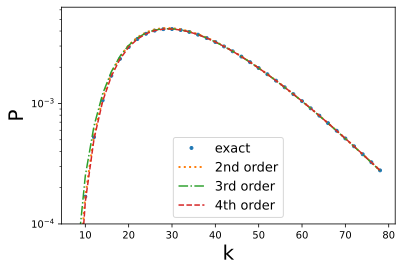

In [18]:
x_start = int(Nu*0.05) 
x_fin = int(Nu/2)

line1, = plt.plot([2*i for i in range(x_start,x_fin, 1)], [P_sectors[m,j]/Z(M) for j in range(x_start,x_fin)],'.' ,label = 'exact')

line2, = plt.plot([2*i for i in range(x_start,x_fin, 1)], [gauss_fun(m, A_2[j], Mu1_2[j], Mu2_2[j]) for j in range(x_start,x_fin, 1)] , linewidth=2, linestyle = ':', label = '2nd order')

line3, = plt.plot([2*i for i in range(x_start,x_fin, 1)], [gauss_fun(m, A_3[j], Mu1_3[j], Mu2_3[j], Mu3_3[j]) for j in range(x_start,x_fin, 1)] , linestyle = '-.', label = '3rd order')

line4, = plt.plot([2*i for i in range(x_start,x_fin, 1)], [gauss_fun(m, A_4[z], Mu1_4[z], Mu2_4[z], Mu3_4[z], Mu4_4[z]) for z in range(x_start,x_fin, 1)] , linestyle = '--', label = '4th order')

plt.yscale('log') 
plt.legend(handles=[line1, line2,line3,line4], prop={'size':13}, loc='lower center', title_fontsize = '13' ) 
plt.xlabel('k',fontsize=20) 
plt.ylabel('P',fontsize=20) 
plt.ylim([10**(-4),10**(-2.2)])

plt.show()

In [19]:
# Warning! 
# Choosing of k_0 and k_cut (cut off of the number of sectors) is heuristic
# The 3rd and 4th order might give the 'nan' result  due to the function's kind.  

cut_off_ = np.zeros(Nu)
for i in range(Nu):
    if gauss_fun(m, A_4[i],Mu1_4[i], Mu2_4[i],Mu3_4[i],Mu4_4[i] ) == gauss_fun(m, A_4[i],Mu1_4[i], Mu2_4[i],Mu3_4[i],Mu4_4[i] ): # excludes 'nan'  
        cut_off_[i] = gauss_fun(m, A_4[i],Mu1_4[i], Mu2_4[i],Mu3_4[i],Mu4_4[i] )
        
k_max = list(cut_off_).index(np.max(cut_off_))


# You can vary 'accur' to obtain more precise results 

accur = 1000


# Let's find the left cut off over sectors 
k_0 = 1

for j in range(int(Nu/10)):
    
    if  gauss_fun(m, A_4[j],Mu1_4[j], Mu2_4[j],Mu3_4[j], Mu4_4[j] ) < 10**(-12): # > 10**(-12) and A_2[i,j]!= 0 :
        k_0 = j              

# Let's find the right cut off over sectors  

p_4 = 0 

i = k_max

while cut_off_[k_max]/cut_off_[i] < accur and i < Nu - 1:
    
    p_4 += gauss_fun(m, A_4[k], Mu1_4[k], Mu2_4[k], Mu3_4[k], Mu4_4[k]) 

    i += 1
    
k_cut = i  
    
# The probability computation for different orders of approximation

p_2 = 0
p_3 = 0
p_4 = 0


for k in range(k_0, k_cut):
    p_2 += gauss_fun(m, A_2[k], Mu1_2[k], Mu2_2[k]) 
    p_3 += gauss_fun(m, A_3[k], Mu1_3[k], Mu2_3[k], Mu3_3[k])
    p_4 += gauss_fun(m, A_4[k], Mu1_4[k], Mu2_4[k], Mu3_4[k], Mu4_4[k])

p_4_new = p_4

if p_4 > 10*p_2 or (p_4 == p_4)==False:
    while p_4_new > 10*p_2 and (p_4 == p_4)==False:
        k_cut -= 1 

        p_4_new = 0 
        for k in range(k_0, k_cut):
            p_4_new += gauss_fun(m, A_4[k], Mu1_4[k], Mu2_4[k], Mu3_4[k], Mu4_4[k])
            
    p_4 = p_4_new
    
p_3 = 0 
for k in range(k_0, k_cut):
    p_3 += gauss_fun(m, A_3[k], Mu1_3[k], Mu2_3[k], Mu3_3[k])   

print('K_cut_off = (' , k_0*2, ',', k_cut*2,')\n')
print('P_exact = ', "{:.3e}".format(P_list_ours[len(unique_permutations)-1]), '\n','   P_2 = ' , "{:.3e}".format(p_2), '\n', '   P_3 = ' , "{:.3e}".format(p_3), '\n','   P_4 = ' , "{:.3e}".format(p_4), '\n',)

    

K_cut_off = ( 4 , 98 )

P_exact =  7.251e-02 
    P_2 =  7.322e-02 
    P_3 =  7.314e-02 
    P_4 =  7.202e-02 

